In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [17]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/nuc-conc_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [18]:
### filter trainXY ###
trainXY = XY.loc[XY['Burnup'] < 10000].copy() #Need to explicitly tell pandas not to worry that I'm making a copy
#trainXY = XY.sample(frac=0.1)

In [19]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [20]:
trainXY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
22961,4096.38,0.462283,1.60,vver440,pwr,0.002553,1.2310,1.1460,0.014980,0.2896,1.142,0.04007,0.002379,6.893,0.6434,0.1169,0.004374,0.01052,0.19760,0.10050
7978,4179.92,22.943462,1.83,bw15x15,pwr,0.002981,1.2550,1.2470,0.015680,0.2831,1.164,0.04278,0.002541,7.143,0.6640,0.1308,0.005055,0.01617,0.20230,0.10250
16400,5940.97,0.449756,2.89,abb8x8-1,bwr,0.005316,1.7750,1.7000,0.031950,0.4979,1.650,0.06710,0.005198,8.610,1.1200,0.3061,0.018610,0.01045,0.30120,0.15730
7635,9408.40,382.597760,0.50,bw15x15,pwr,0.010030,2.8200,2.7820,0.045360,0.5575,2.556,0.11590,0.009716,9.396,1.9140,0.5173,0.054120,0.01526,0.48630,0.26340
12761,8800.68,27.219457,0.51,ge9x9-2,bwr,0.009001,2.6470,2.6090,0.050030,0.6886,2.440,0.10180,0.008540,8.189,1.6260,0.3939,0.039380,0.01335,0.44910,0.24990
1474,6317.27,5391.852336,2.04,ce16x16,pwr,0.006368,1.8850,1.8770,0.000262,0.4316,1.251,0.07432,0.001791,9.669,1.3210,0.1914,0.024010,0.01702,0.32130,0.16570
6161,1863.35,2899.111242,4.20,s14x14,pwr,0.001034,0.5568,0.5605,0.000268,0.1418,0.431,0.01728,0.000322,4.838,0.2088,0.0173,0.000418,0.01697,0.07942,0.03698
7447,6017.97,3915.063354,4.76,s18x18,pwr,0.007799,1.7660,1.7700,0.001242,0.5061,1.301,0.07940,0.003085,13.420,1.5550,0.3844,0.034630,0.02152,0.31230,0.14990
22508,7882.05,0.000502,4.22,svea100-0,bwr,0.010090,2.3240,2.2400,0.064750,0.7156,2.177,0.10660,0.010610,12.430,1.8840,0.8149,0.064800,0.01177,0.41520,0.21060
19338,8061.96,1.185514,2.96,atrium10x10-9,bwr,0.009942,2.3860,2.3060,0.064450,0.7093,2.229,0.10800,0.010640,11.750,1.8050,0.7460,0.062570,0.01267,0.42450,0.21810


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [22]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 22509
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
22509,7882.05,0.357616,4.22,svea100-0,bwr,0.01011,2.324,2.242,0.06473,0.7167,2.177,0.1068,0.01061,12.45,1.884,0.8148,0.06481,0.01229,0.4152,0.2106


In [23]:
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
test_sample

,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
22509,0.01011,2.324,2.242,0.06473,0.7167,2.177,0.1068,0.01061,12.45,1.884,0.8148,0.06481,0.01229,0.4152,0.2106


In [24]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [25]:
row_unc = 0.14
test_unc = 0.14
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc), axis=1)

In [26]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [27]:
trainXY.head(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,LogLikelihood,LLUncertainty
0,0.00,0.000000,0.5,ce14x14,pwr,0.000000,0.0000,0.0000,0.000000,0.0000,...,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.00000,0.00000,-4451.978322,0.000000e+00
1,2165.43,0.000652,0.5,ce14x14,pwr,0.000673,0.6591,0.5623,0.002844,0.1280,...,0.000526,2.767,0.1383,0.008548,0.000164,0.008145,0.09504,0.04642,-2688.590922,1.118621e+06
2,2165.43,0.621994,0.5,ce14x14,pwr,0.000681,0.6596,0.5687,0.002843,0.1303,...,0.000526,2.798,0.1383,0.008548,0.000164,0.009156,0.09504,0.04643,-2672.640504,1.118621e+06
3,2165.43,1.016193,0.5,ce14x14,pwr,0.000686,0.6596,0.5727,0.002842,0.1315,...,0.000526,2.815,0.1383,0.008547,0.000164,0.009706,0.09504,0.04643,-2663.898847,1.118621e+06
4,2165.43,6.259976,0.5,ce14x14,pwr,0.000746,0.6596,0.6132,0.002829,0.1331,...,0.000526,2.923,0.1383,0.008541,0.000164,0.013080,0.09504,0.04643,-2607.664020,1.118626e+06
5,2165.43,33.204962,0.5,ce14x14,pwr,0.000888,0.6596,0.6542,0.002760,0.1331,...,0.000522,2.953,0.1383,0.008511,0.000164,0.013890,0.09504,0.04643,-2589.829672,1.118653e+06
6,2165.43,368.004536,0.5,ce14x14,pwr,0.000933,0.6596,0.6554,0.002029,0.1331,...,0.000485,2.953,0.1383,0.008141,0.000164,0.013890,0.09504,0.04643,-2590.764215,1.119037e+06
7,2165.43,2333.086414,0.5,ce14x14,pwr,0.000933,0.6596,0.6554,0.000333,0.1331,...,0.000315,2.952,0.1382,0.006271,0.000164,0.013890,0.09504,0.04643,-2597.054621,1.154685e+06
8,2165.43,3842.037673,0.5,ce14x14,pwr,0.000933,0.6596,0.6554,0.000083,0.1331,...,0.000225,2.952,0.1381,0.005132,0.000164,0.013890,0.09504,0.04643,-2601.183889,4.450620e+06
9,2165.43,0.000000,0.5,ce14x14,pwr,0.000673,0.6591,0.5623,0.002844,0.1280,...,0.000526,2.767,0.1383,0.008548,0.000164,0.008143,0.09504,0.04642,-2688.590922,1.118621e+06


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [28]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: 10.845478715660157 +/- 3.1547778532043216


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
7095,pwr,0.0,2.99,8188.74,s18x18


#### BWR

In [29]:
max_bwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'bwr'].max()
idx_bwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'bwr'].idxmax()
unc_bwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_bwr])
print(f'Max Log Likelihood for BWRs: {max_bwr} +/- {unc_bwr}')
trainXY.loc[trainXY.index == idx_bwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for BWRs: 15.707614847522406 +/- 0.0


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
22509,bwr,0.357616,4.22,7882.05,svea100-0


#### PHWR

In [30]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: -788.9980001276048 +/- 382.95377846979943


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
24747,phwr,1812.172599,0.711,9767.27,candu37


## LL wrt Burnup and Cool Time

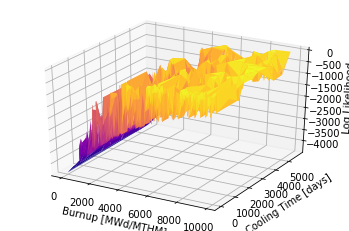

In [31]:
x = trainXY['Burnup']
y = trainXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = trainXY['LogLikelihood']

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap=plt.cm.plasma)
ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(12398, 16)

In [24]:
mod = NormMod(y, X)

In [25]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 2040419.517299
         Iterations: 5464
         Function evaluations: 7309
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -2.5297e+10
Model:                        NormMod   AIC:                         5.059e+10
Method:            Maximum Likelihood   BIC:                         5.059e+10
Date:                Tue, 20 Aug 2019                                         
Time:                        13:00:39                                         
No. Observations:               12398                                         
Df Residuals:                   12382                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------